# The Robert and Rosenbaum Uncertainty Zones model

# An application to FX Futures at CME

## Implementation by
## Marcos Costa Santos Carreira (École Polytechnique - CMAP)
## and
## Florian Huchedé (CME)
## Jul-2019

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
pd.set_option('display.max_rows', 200)

In [4]:
import glob

## File paths

In [5]:
PATHPROJ = '/Users/marcoscscarreira/Documents/X/CME project/CME_data/'
#URL_ROOT = 'https://raw.githubusercontent.com/MarcosCarreira/UZStats/master/CME_data/'

In [6]:
PATH_EUR_PRIOR = PATHPROJ+'EUR/prior/'
PATH_EUR_AFTER = PATHPROJ+'EUR/after/'
#URL_EUR_1 = 'EUR/prior/'
#URL_EUR_2 = 'EUR/after/'
#PATH_EUR_PRIOR = URL_ROOT+URL_EUR_1
#PATH_EUR_AFTER = URL_ROOT+URL_EUR_2

In [7]:
PATH_MXN_PRIOR = PATHPROJ+'MXN/prior/'
PATH_MXN_AFTER = PATHPROJ+'MXN/after/'
#URL_MXN_1 = 'MXN/prior/'
#URL_MXN_2 = 'MXN/after/'
#PATH_MXN_PRIOR = URL_ROOT+URL_MXN_1
#PATH_MXN_AFTER = URL_ROOT+URL_MXN_2

In [8]:
PATH_CAD_PRIOR = PATHPROJ+'CAD/prior/'
PATH_CAD_AFTER = PATHPROJ+'CAD/after/'
#URL_CAD_1 = 'CAD/prior/'
#URL_CAD_2 = 'CAD/after/'
#PATH_CAD_PRIOR = URL_ROOT+URL_CAD_1
#PATH_CAD_AFTER = URL_ROOT+URL_CAD_2

In [9]:
PATH_JPY_PRIOR = PATHPROJ+'JPY/prior/'
PATH_JPY_AFTER = PATHPROJ+'JPY/after/'
#URL_JPY_1 = 'JPY/prior/'
#URL_JPY_2 = 'JPY/after/'
#PATH_JPY_PRIOR = URL_ROOT+URL_JPY_1
#PATH_JPY_AFTER = URL_ROOT+URL_JPY_2

## Load files

In [10]:
def list_files(path, range1_0, range1_1, range2):
    files_list = [f for f in glob.glob(PATHPROJ+path+'*_CAticks.csv',\
                                    recursive=True)]
    files_list.sort()
    return [[f[range1_0:range1_1], f[range2:range2+8]] for f in files_list]

In [11]:
def add_x(contract):
    if (contract[-1] == '6') & (len(contract) == 4):
        return 'x'+contract
    else:
        return contract

In [136]:
def list_files2(path):
    files_list = [f for f in glob.glob(PATHPROJ+path+'*_CAticks.csv',\
                                    recursive=True)]
    files_list.sort()
    return [[f[67:71], f[72:72+len(f)-84]] for f in files_list]

In [148]:
def add_20(date):
    if (len(date) == 6):
        return '20'+date[4:]+date[:4]
    else:
        return date

In [12]:
def process_files(path, files_list, status, tick_value):
    full_path = PATHPROJ+path
    cdates = pd.DataFrame(files_list, columns=['Contract', 'Date'])
    cdates['Status'] = status
    cdates['Tick'] = tick_value
    files_CAticks = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_CAticks.csv' for j in range(len(cdates))]
    files_COSTtrades = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_COSTtrades.csv' for j in range(len(cdates))]
    files_OBstats = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_OBstats.csv' for j in range(len(cdates))]
    files_OTtrans = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_OTtrans.csv' for j in range(len(cdates))]
    files_RDFtrans = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_RDFtrans.csv' for j in range(len(cdates))]
    files_UZstats = [full_path+cdates['Contract'].iloc[j]+\
                           '_'+cdates['Date'].iloc[j]+\
                          '_UZstats.csv' for j in range(len(cdates))]
    return [cdates, files_CAticks, files_COSTtrades, files_OBstats,\
               files_OTtrans, files_RDFtrans, files_UZstats]

## OB and UZ Stats

In [13]:
def ob_uz_stats(cdates, files_OBstats, files_UZstats, files_CAticks):
    df_stats = pd.DataFrame()
    for j in range(len(cdates)):
        new_row_1 = pd.read_csv(files_OBstats[j], index_col=0)
        new_row_2 = pd.read_csv(files_UZstats[j], index_col=0)
        new_row = pd.concat([new_row_1, new_row_2], axis=1, sort=False)
        new_row['lambda1'] = pd.read_csv(files_CAticks[j],\
            index_col=0).set_index('Li').loc[1]['lamb']
        df_stats = df_stats.append(new_row)   
    df_stats.reset_index(drop=True, inplace=True)
    df_stats['Contract'] = cdates['Contract']      
    df_stats['Date'] = pd.to_datetime(cdates['Date'])
    df_stats['Status'] = cdates['Status']
    df_stats['Tick'] = cdates['Tick']
    df_stats.set_index(['Date'], inplace=True)
    df_stats.sort_index(inplace=True)
    df_stats['ndfpr_pred'] = ((df_stats['rvxe']*df_stats['spot_avg']/df_stats['Tick'])**2)/(2*df_stats['eta1'])
    df_stats['eta*alpha*sqrt(M)'] = df_stats['eta1']*df_stats['Tick']*np.sqrt(df_stats['M'])
    df_stats['S*sqrt(M)'] = df_stats['twspr1']*df_stats['Tick']*np.sqrt(df_stats['M'])
    df_stats['sigma'] = df_stats['rvxe']*df_stats['spot_avg']
    return df_stats

## Linear regression

In [14]:
def lin_reg(data, dependent, independent, logdata=False):
    X = data[dependent]
    Y = data[independent]
    if logdata:
        X = np.log(X)
        Y = np.log(Y)
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
    print_model = model.summary()
    print(print_model)

### EUR

In [15]:
EUR_PRIOR_CDATES_LIST = list_files('EUR/PRIOR/', -25, -21, -20)

In [16]:
EUR_PRIOR_CDATES_LIST = [[add_x(x[0]), x[1]] for x in EUR_PRIOR_CDATES_LIST]

In [17]:
EUR_PRIOR_CDATES, FILES_EUR_PRIOR_CAticks, FILES_EUR_PRIOR_COSTtrades,\
    FILES_EUR_PRIOR_OBstats, FILES_EUR_PRIOR_OTtrans,\
    FILES_EUR_PRIOR_RDFtrans, FILES_EUR_PRIOR_UZstats = \
    process_files('EUR/PRIOR/', EUR_PRIOR_CDATES_LIST, 'prior', 1.0)

In [18]:
EUR_PRIOR_OB_UZ_STATS = ob_uz_stats(EUR_PRIOR_CDATES, FILES_EUR_PRIOR_OBstats,\
    FILES_EUR_PRIOR_UZstats, FILES_EUR_PRIOR_CAticks)

In [19]:
EUR_AFTER_CDATES_LIST = list_files('EUR/AFTER/', -26, -21, -20)

In [20]:
EUR_AFTER_CDATES, FILES_EUR_AFTER_CAticks, FILES_EUR_AFTER_COSTtrades,\
    FILES_EUR_AFTER_OBstats, FILES_EUR_AFTER_OTtrans,\
    FILES_EUR_AFTER_RDFtrans, FILES_EUR_AFTER_UZstats = \
    process_files('EUR/AFTER/', EUR_AFTER_CDATES_LIST, 'after', 0.5)

In [21]:
EUR_AFTER_OB_UZ_STATS = ob_uz_stats(EUR_AFTER_CDATES, FILES_EUR_AFTER_OBstats,\
    FILES_EUR_AFTER_UZstats, FILES_EUR_AFTER_CAticks)

In [22]:
EUR_OB_UZ_STATS = pd.concat([EUR_PRIOR_OB_UZ_STATS, EUR_AFTER_OB_UZ_STATS], sort=False)

### MXN

In [23]:
MXN_PRIOR_CDATES_LIST = list_files('MXN/PRIOR/', -25, -21, -20)

In [24]:
MXN_PRIOR_CDATES, FILES_MXN_PRIOR_CAticks, FILES_MXN_PRIOR_COSTtrades,\
    FILES_MXN_PRIOR_OBstats, FILES_MXN_PRIOR_OTtrans,\
    FILES_MXN_PRIOR_RDFtrans, FILES_MXN_PRIOR_UZstats = \
    process_files('MXN/PRIOR/', MXN_PRIOR_CDATES_LIST, 'prior', 25.0)

In [25]:
MXN_PRIOR_OB_UZ_STATS = ob_uz_stats(MXN_PRIOR_CDATES, FILES_MXN_PRIOR_OBstats,\
    FILES_MXN_PRIOR_UZstats, FILES_MXN_PRIOR_CAticks)

In [26]:
MXN_AFTER_CDATES_LIST = list_files('MXN/AFTER/', -25, -21, -20)

In [27]:
MXN_AFTER_CDATES, FILES_MXN_AFTER_CAticks, FILES_MXN_AFTER_COSTtrades,\
    FILES_MXN_AFTER_OBstats, FILES_MXN_AFTER_OTtrans,\
    FILES_MXN_AFTER_RDFtrans, FILES_MXN_AFTER_UZstats = \
    process_files('MXN/AFTER/', MXN_AFTER_CDATES_LIST, 'after', 10.0)

In [28]:
MXN_AFTER_OB_UZ_STATS = ob_uz_stats(MXN_AFTER_CDATES, FILES_MXN_AFTER_OBstats,\
    FILES_MXN_AFTER_UZstats, FILES_MXN_AFTER_CAticks)

In [29]:
MXN_OB_UZ_STATS = pd.concat([MXN_PRIOR_OB_UZ_STATS, MXN_AFTER_OB_UZ_STATS], sort=False)

### CAD

In [165]:
CAD_PRIOR_CDATES_LIST = list_files2('CAD/PRIOR/')

In [166]:
#CAD_PRIOR_CDATES_LIST = [[x[0], add_20(x[1])] for x in CAD_PRIOR_CDATES_LIST]

In [167]:
CAD_PRIOR_CDATES, FILES_CAD_PRIOR_CAticks, FILES_CAD_PRIOR_COSTtrades,\
    FILES_CAD_PRIOR_OBstats, FILES_CAD_PRIOR_OTtrans,\
    FILES_CAD_PRIOR_RDFtrans, FILES_CAD_PRIOR_UZstats = \
    process_files('CAD/PRIOR/', CAD_PRIOR_CDATES_LIST, 'prior', 1.0)

In [168]:
CAD_PRIOR_OB_UZ_STATS = ob_uz_stats(CAD_PRIOR_CDATES, FILES_CAD_PRIOR_OBstats,\
    FILES_CAD_PRIOR_UZstats, FILES_CAD_PRIOR_CAticks)

## Charts

In [61]:
def time_series_plot(database, field, title):
    df_plot = database[[field, 'Status']].copy()
    df_plot['prior'] = np.where(df_plot['Status'] == 'prior', df_plot[field], np.nan)
    df_plot['after'] = np.where(df_plot['Status'] == 'after', df_plot[field], np.nan)
    df_plot[['prior', 'after']].plot(figsize=(9,6), title=title)

In [63]:
def twspr_plot_USD(database):
    df_plot = database[['twspr1', 'Tick', 'Status']].copy()
    df_plot['twspr1'] = df_plot['twspr1']*df_plot['Tick']
    time_series_plot(df_plot, 'twspr1', 'Spread in USD')

In [81]:
def time_series_hist(database, field, title):
    df_plot = database[[field, 'Status']].copy()
    df_plot['prior'] = np.where(df_plot['Status'] == 'prior', df_plot[field], np.nan)
    df_plot['after'] = np.where(df_plot['Status'] == 'after', df_plot[field], np.nan)
    df_plot[['prior','after']].plot.hist(alpha=0.5, figsize=(9,6))
    plt.title(title)

In [85]:
def scatter_plot(database, field1, field2, title):
    plt.figure(figsize=(9, 6))
    plt.title(title)
    sns.scatterplot(x=field1, y=field2, hue='Status',\
            data=database);

In [89]:
def cloud1(database):
    sns.lmplot(x='eta*alpha*sqrt(M)', y='sigma', hue='Status', data=database,\
              height=6, aspect=1.5);
    plt.title(r' Cloud ('
              r'$\eta\alpha\sqrt{M}, \sigma)$');
    plt.xlabel(r'$\eta\alpha\sqrt{M}$');
    plt.ylabel(r'$\sigma$');

In [97]:
def cloud2(database):
    sns.lmplot(x='p1*eta*alpha*sqrt(M)', y='sigma-p2*S*sqrt(M)', hue='Status', data=database,\
              height=6, aspect=1.5);
    plt.title(r' Cloud ('
              r'$p_{1}\eta\alpha\sqrt{M}, \sigma-p_{2}S\sqrt{M})$');
    plt.xlabel(r'$p_{1}\eta\alpha\sqrt{M}$');
    plt.ylabel(r'$\sigma-p_{2}S\sqrt{M}$');

In [100]:
def regr_plot(database, field1, field2):
    sns.lmplot(x=field1, y=field2, hue='Status', aspect=1, \
            height=7, data=database);

### EUR

In [118]:
EUR_OB_UZ_STATS.head()

,ask12qty,ask12tomid,ask1qty,ask1tomid,bid12qty,bid12tomid,bid1qty,bid1tomid,twspr1,twspr2,chgavg,dt_alt,dt_avg,dt_cont,duration,eta1,ndfpr,rvp,rvx,rvxe,spot_avg,M,S1,Volume,lambda1,Contract,Status,Tick
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-06-15,84.895356,1.302916,21.446649,0.540151,86.372931,1.301542,21.800740,0.540151,1.080303,3.080303,1.013926,6.437141,6.914228,7.697317,7.463422,0.305501,4165.0,0.005849,0.004600,0.004572,11265.414786,18439.0,0.983966,77463.0,0.986315,6EU5,prior,1.0
2015-06-16,104.524580,1.433306,26.959599,0.704683,100.018134,1.453215,25.305117,0.704683,1.409366,3.409399,1.004864,9.827628,11.671624,15.042785,12.934252,0.274686,2467.0,0.004449,0.003307,0.003298,11249.240681,12485.0,0.990848,57557.0,0.995541,6EU5,prior,1.0
2015-06-17,91.924172,1.436725,23.499954,0.679752,94.414306,1.420455,24.159480,0.679752,1.359505,3.360043,1.071401,2.634866,2.752637,2.937431,2.287043,0.311061,10462.0,0.010530,0.008795,0.008306,11303.325146,35934.0,0.953007,144455.0,0.951443,6EU5,prior,1.0
2015-06-18,82.989397,1.350425,20.797045,0.630599,90.809792,1.347677,24.467065,0.630599,1.261199,3.347028,1.022165,4.115989,4.659191,5.627517,4.795632,0.281467,6181.0,0.007208,0.005517,0.005408,11402.745875,25434.0,0.980988,114425.0,0.980424,6EU5,prior,1.0
2015-06-19,111.054435,1.306565,26.601901,0.529959,109.591411,1.306342,25.871195,0.529959,1.059919,3.060076,1.011976,9.385253,10.143702,11.629115,10.986831,0.256183,2839.0,0.004783,0.003455,0.003423,11354.491901,13574.0,0.987373,64525.0,0.989433,6EU5,prior,1.0


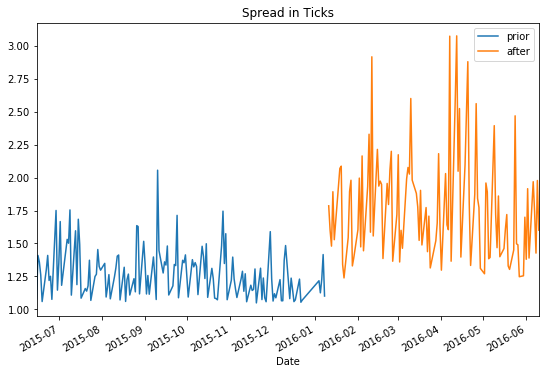

In [62]:
time_series_plot(EUR_OB_UZ_STATS, 'twspr1', 'Spread in Ticks')

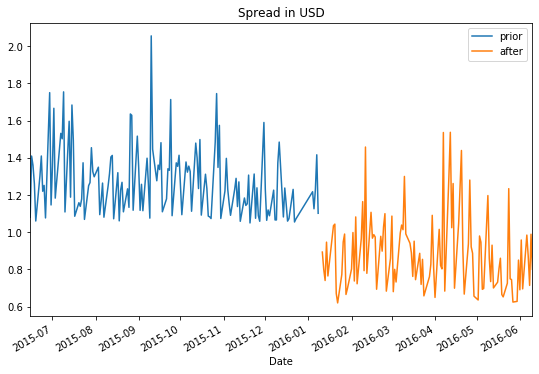

In [64]:
twspr_plot_USD(EUR_OB_UZ_STATS)

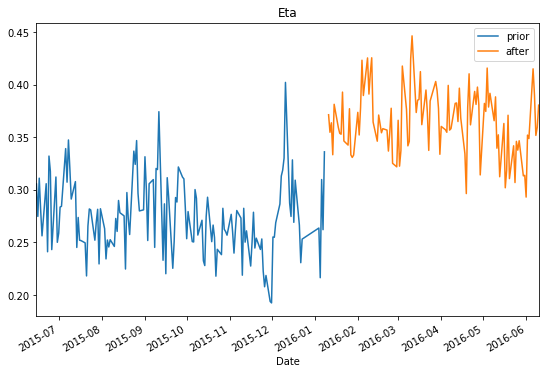

In [65]:
time_series_plot(EUR_OB_UZ_STATS, 'eta1', 'Eta')

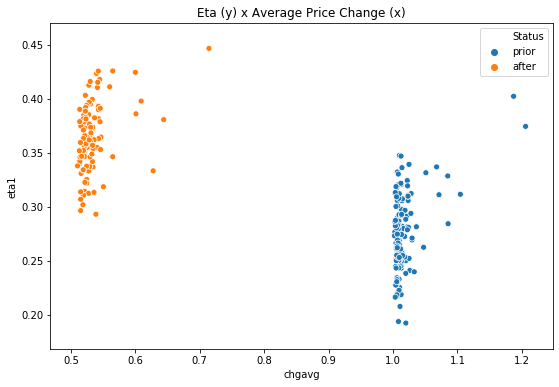

In [86]:
scatter_plot(EUR_OB_UZ_STATS, 'chgavg', 'eta1', 'Eta (y) x Average Price Change (x)')

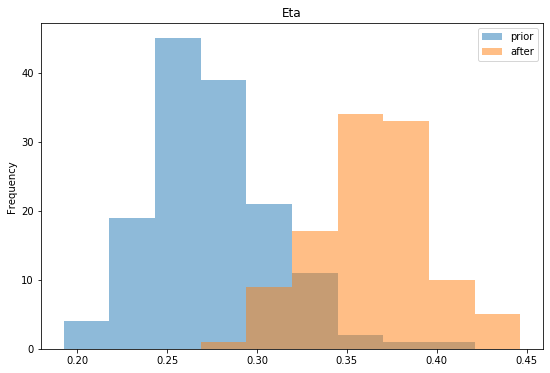

In [82]:
time_series_hist(EUR_OB_UZ_STATS, 'eta1', 'Eta')

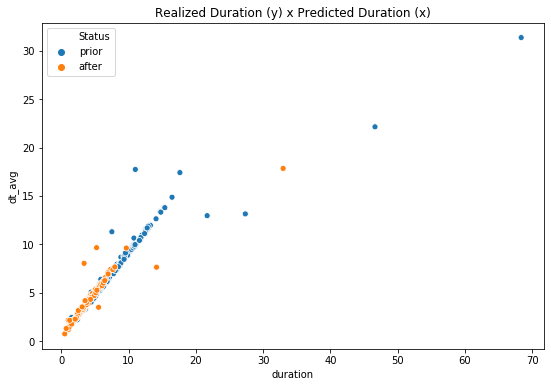

In [87]:
scatter_plot(EUR_OB_UZ_STATS, 'duration', 'dt_avg', 'Realized Duration (y) x Predicted Duration (x)')

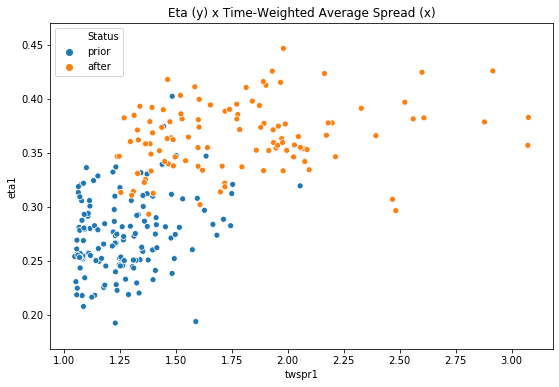

In [88]:
scatter_plot(EUR_OB_UZ_STATS, 'twspr1', 'eta1', 'Eta (y) x Time-Weighted Average Spread (x)')

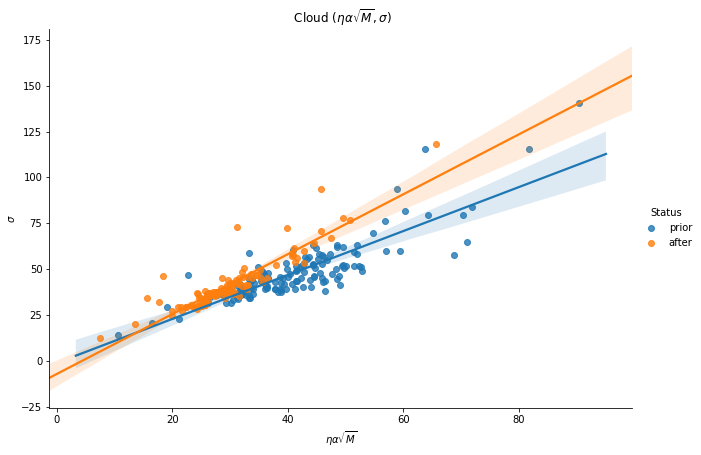

In [90]:
cloud1(EUR_OB_UZ_STATS)

In [91]:
lin_reg(EUR_PRIOR_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     193.9
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.47e-41
Time:                        23:15:55   Log-Likelihood:                -506.90
No. Observations:                 143   AIC:                             1020.
Df Residuals:                     140   BIC:                             1029.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.7800      2.91

/Applications/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [92]:
lin_reg(EUR_AFTER_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     245.4
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           1.67e-40
Time:                        23:15:56   Log-Likelihood:                -352.85
No. Observations:                 109   AIC:                             711.7
Df Residuals:                     106   BIC:                             719.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.4048      2.30

In [94]:
EUR_OB_UZ_STATS['p1*eta*alpha*sqrt(M)'] = np.where(EUR_OB_UZ_STATS['Status']=='prior', 1.0976, 1.5457)*EUR_OB_UZ_STATS['eta*alpha*sqrt(M)']
EUR_OB_UZ_STATS['sigma-p2*S*sqrt(M)'] = EUR_OB_UZ_STATS['sigma']-\
    np.where(EUR_OB_UZ_STATS['Status']=='prior', 0.0300, 0.0190)*EUR_OB_UZ_STATS['S*sqrt(M)']

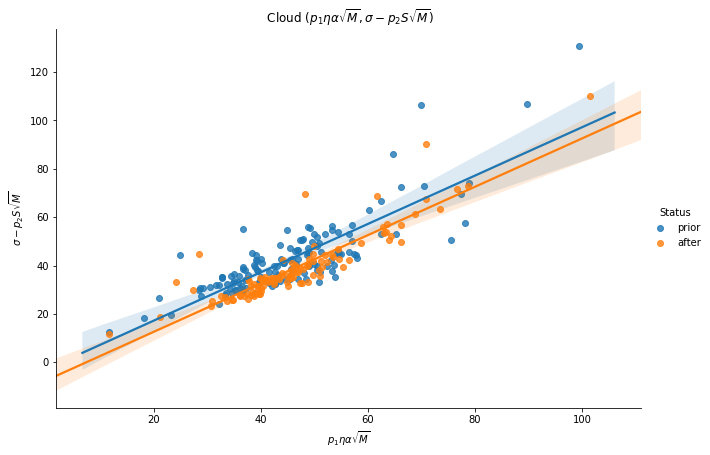

In [98]:
cloud2(EUR_OB_UZ_STATS)

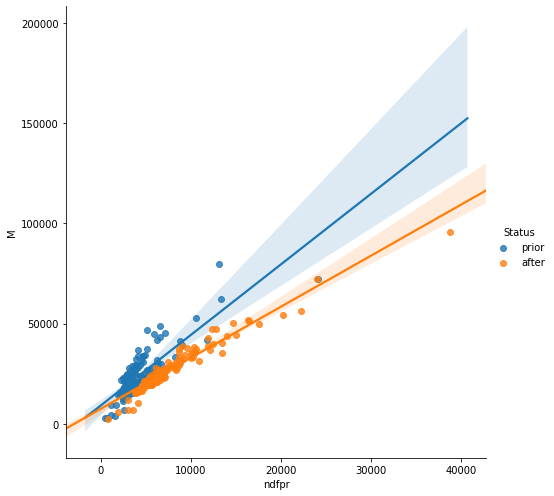

In [101]:
regr_plot(EUR_OB_UZ_STATS, 'ndfpr', 'M')

In [102]:
lin_reg(EUR_PRIOR_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     318.5
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           5.42e-38
Time:                        23:23:11   Log-Likelihood:                -1453.1
No. Observations:                 143   AIC:                             2910.
Df Residuals:                     141   BIC:                             2916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9130.7797    992.942      9.196      0.0

In [103]:
lin_reg(EUR_AFTER_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1425.
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           1.14e-63
Time:                        23:23:11   Log-Likelihood:                -1042.4
No. Observations:                 109   AIC:                             2089.
Df Residuals:                     107   BIC:                             2094.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7469.9713    647.089     11.544      0.0

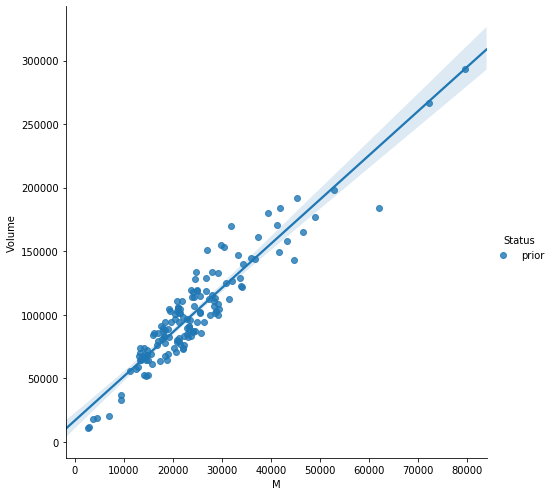

In [105]:
regr_plot(EUR_PRIOR_OB_UZ_STATS, 'M', 'Volume')

In [106]:
lin_reg(EUR_PRIOR_OB_UZ_STATS, 'M', 'Volume')

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1049.
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           3.61e-67
Time:                        23:24:14   Log-Likelihood:                -1572.4
No. Observations:                 143   AIC:                             3149.
Df Residuals:                     141   BIC:                             3155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.682e+04   2862.788      5.875      0.0

### MXN

In [107]:
MXN_OB_UZ_STATS.head()

,ask12qty,ask12tomid,ask1qty,ask1tomid,bid12qty,bid12tomid,bid1qty,bid1tomid,twspr1,twspr2,chgavg,dt_alt,dt_avg,dt_cont,duration,eta1,ndfpr,rvp,rvx,rvxe,spot_avg,M,S1,Volume,lambda1,Contract,Status,Tick,ndfpr_pred,eta*alpha*sqrt(M),S*sqrt(M),sigma
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-03-17,305.957020,1.907132,86.735495,1.203633,334.102701,2.119174,94.372937,1.203633,2.407267,4.727468,25.555556,151.326158,159.861728,167.872000,168.772406,0.441063,180.0,0.004595,0.004325,0.004316,75379.696133,1787.0,0.981267,16804.0,0.977778,6MM4,prior,25.0,191.974510,466.125344,2544.055101,325.332167
2014-03-18,322.918482,1.988470,97.348282,1.317426,318.693379,2.022331,84.331926,1.317426,2.634853,4.824491,25.000000,103.745757,140.158844,213.176971,158.048821,0.250000,205.0,0.004745,0.003357,0.003355,75432.160194,2365.0,0.996334,19703.0,1.000000,6MM4,prior,25.0,204.999948,303.945410,3203.405743,253.105677
2014-03-19,325.359936,2.170756,92.990349,1.304225,292.880567,2.005041,78.071140,1.304225,2.608450,4.907621,25.347826,43.863738,49.772699,65.044093,53.530582,0.194032,575.0,0.008184,0.005234,0.005098,75154.644097,3759.0,0.988331,24824.0,0.989565,6MM4,prior,25.0,605.261488,297.406473,3998.146884,383.145430
2014-03-20,314.036681,1.810792,87.544723,1.128007,342.126000,2.427985,93.569065,1.128007,2.256013,4.953339,25.440529,108.571187,126.765132,152.662370,134.458413,0.340142,227.0,0.005184,0.004313,0.004276,74862.609649,3182.0,0.984242,26373.0,0.986784,6MM4,prior,25.0,240.966700,479.677914,3181.498513,320.083535
2014-03-21,333.566084,1.334999,87.630982,0.570999,341.668788,1.339283,87.364293,0.570999,1.141998,3.144474,25.308642,113.729112,118.124342,126.799671,128.575013,0.257922,243.0,0.005282,0.003812,0.003794,75128.278689,2791.0,0.997238,21630.0,0.987654,6MM4,prior,25.0,251.992974,340.650554,1508.290897,285.032124


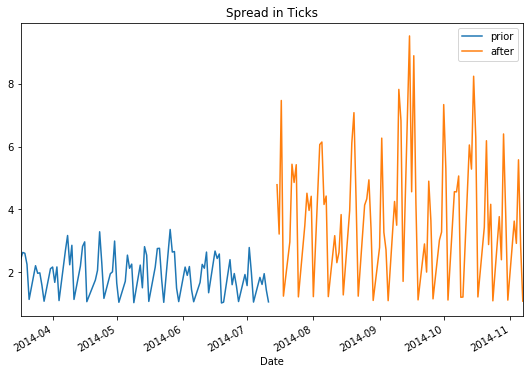

In [108]:
time_series_plot(MXN_OB_UZ_STATS, 'twspr1', 'Spread in Ticks')

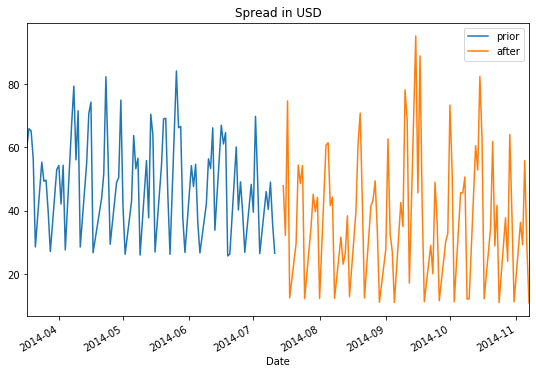

In [109]:
twspr_plot_USD(MXN_OB_UZ_STATS)

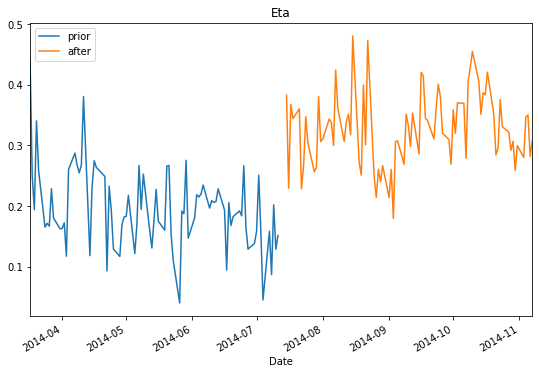

In [110]:
time_series_plot(MXN_OB_UZ_STATS, 'eta1', 'Eta')

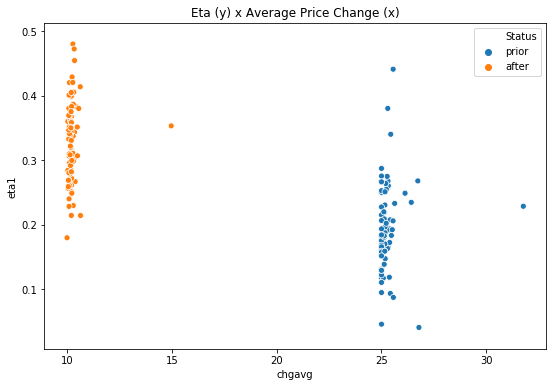

In [111]:
scatter_plot(MXN_OB_UZ_STATS, 'chgavg', 'eta1', 'Eta (y) x Average Price Change (x)')

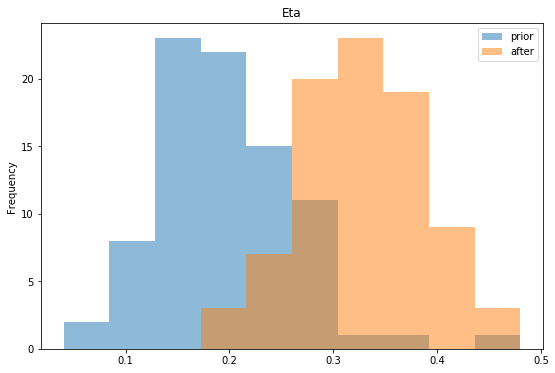

In [112]:
time_series_hist(MXN_OB_UZ_STATS, 'eta1', 'Eta')

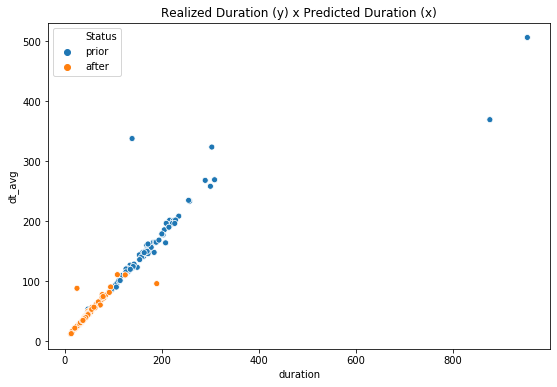

In [113]:
scatter_plot(MXN_OB_UZ_STATS, 'duration', 'dt_avg', 'Realized Duration (y) x Predicted Duration (x)')

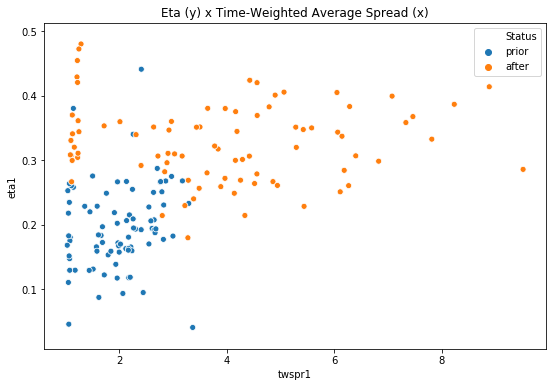

In [114]:
scatter_plot(MXN_OB_UZ_STATS, 'twspr1', 'eta1', 'Eta (y) x Time-Weighted Average Spread (x)')

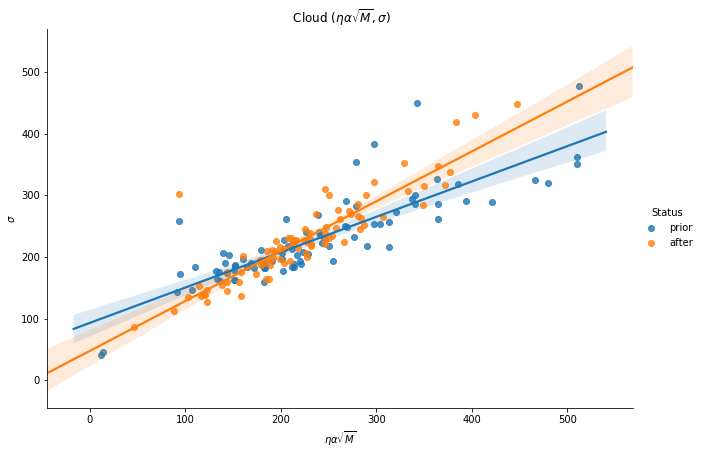

In [115]:
cloud1(MXN_OB_UZ_STATS)

In [116]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     112.1
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.61e-24
Time:                        23:27:08   Log-Likelihood:                -421.03
No. Observations:                  84   AIC:                             848.1
Df Residuals:                      81   BIC:                             855.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                80.8025     11.40

In [117]:
lin_reg(MXN_AFTER_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     189.2
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           2.99e-31
Time:                        23:27:14   Log-Likelihood:                -401.32
No. Observations:                  84   AIC:                             808.6
Df Residuals:                      81   BIC:                             815.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                45.7812      9.95

In [118]:
MXN_OB_UZ_STATS['p1*eta*alpha*sqrt(M)'] = np.where(MXN_OB_UZ_STATS['Status']=='prior', 0.5195, 0.7681)*MXN_OB_UZ_STATS['eta*alpha*sqrt(M)']
MXN_OB_UZ_STATS['sigma-p2*S*sqrt(M)'] = MXN_OB_UZ_STATS['sigma']-\
    np.where(MXN_OB_UZ_STATS['Status']=='prior', 0.0106, 0.0040)*MXN_OB_UZ_STATS['S*sqrt(M)']

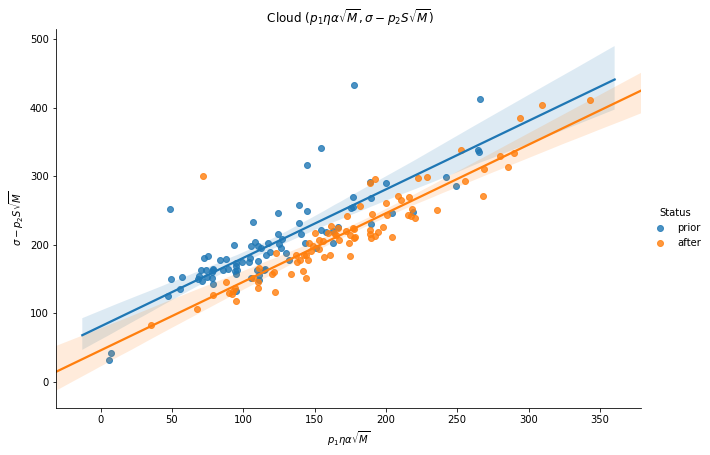

In [120]:
cloud2(MXN_OB_UZ_STATS)

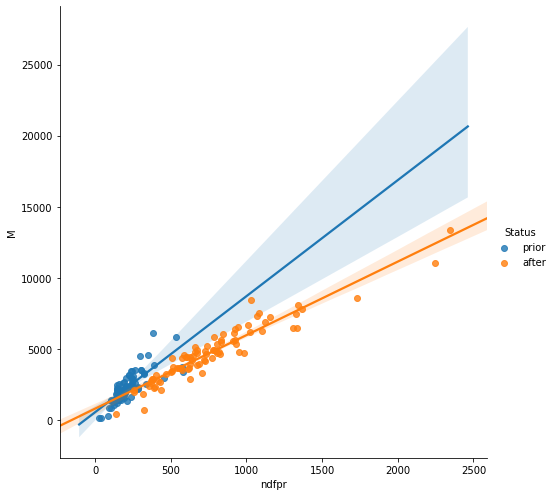

In [121]:
regr_plot(MXN_OB_UZ_STATS, 'ndfpr', 'M')

In [122]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     136.0
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.28e-19
Time:                        23:28:51   Log-Likelihood:                -660.99
No. Observations:                  84   AIC:                             1326.
Df Residuals:                      82   BIC:                             1331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        555.9551    166.679      3.335      0.0

In [123]:
lin_reg(MXN_AFTER_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     730.1
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           1.38e-42
Time:                        23:28:58   Log-Likelihood:                -663.84
No. Observations:                  84   AIC:                             1332.
Df Residuals:                      82   BIC:                             1337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        805.3680    163.235      4.934      0.0

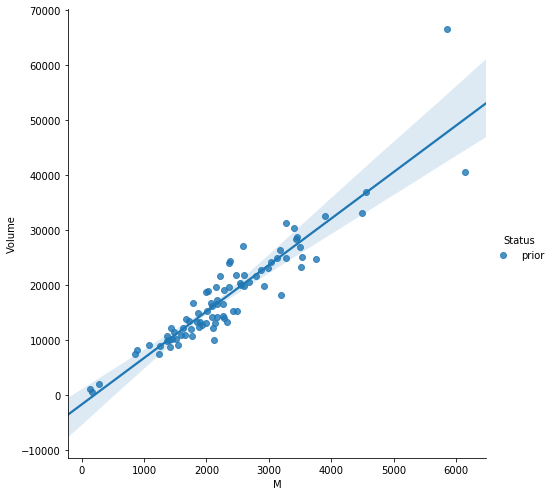

In [124]:
regr_plot(MXN_PRIOR_OB_UZ_STATS, 'M', 'Volume')

In [125]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, 'M', 'Volume')

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     510.3
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           5.85e-37
Time:                        23:29:09   Log-Likelihood:                -804.53
No. Observations:                  84   AIC:                             1613.
Df Residuals:                      82   BIC:                             1618.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1640.7218    949.912     -1.727      0.0

### CAD

In [169]:
CAD_PRIOR_OB_UZ_STATS.head()

,ask12qty,ask12tomid,ask1qty,ask1tomid,bid12qty,bid12tomid,bid1qty,bid1tomid,twspr1,twspr2,chgavg,dt_alt,dt_avg,dt_cont,duration,eta1,ndfpr,rvp,rvx,rvxe,spot_avg,M,S1,Volume,lambda1,Contract,Status,Tick,ndfpr_pred,eta*alpha*sqrt(M),S*sqrt(M),sigma
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,163.120470,1.469545,41.834012,0.721800,162.407902,1.473448,41.079484,0.721800,1.443599,3.443901,1.014275,20.419302,21.636732,23.788150,22.921076,0.284745,1331.0,0.005238,0.004010,0.003953,7177.289039,10106.0,0.989594,41446.0,0.990984,6CH6,prior,1.0,1413.546179,28.625034,145.123039,28.372538
2016-01-05,160.443245,1.476628,40.675003,0.732374,160.854730,1.498176,38.169971,0.732374,1.464747,3.464747,1.011130,14.934999,16.025562,17.894739,17.409969,0.296461,1797.0,0.006031,0.004664,0.004644,7153.408788,10596.0,0.989702,41676.0,0.989983,6CH6,prior,1.0,1861.002752,30.516751,150.776507,33.217899
2016-01-06,149.847669,1.517572,35.245901,0.727492,163.973841,1.476599,41.161758,0.727492,1.454984,3.454984,1.008270,18.690054,19.840139,21.623837,21.788861,0.328475,1451.0,0.005429,0.004413,0.004401,7102.264463,10248.0,0.991887,37624.0,0.991730,6CH6,prior,1.0,1486.998319,33.252282,147.291495,31.255121
2016-01-07,152.211157,1.494877,39.153553,0.758097,149.136912,1.522182,36.808219,0.758097,1.516194,3.516213,1.007030,16.244726,16.869728,17.756971,18.587935,0.359977,1707.0,0.005878,0.004996,0.004987,7103.293911,12670.0,0.991602,47080.0,0.992970,6CH6,prior,1.0,1743.066153,40.519399,170.664444,35.424953
2016-01-08,147.641278,1.325750,39.174093,0.571090,145.593269,1.320379,38.733100,0.571090,1.142180,3.142770,1.017266,20.356575,20.701204,21.151346,22.160731,0.408923,1390.0,0.005403,0.004901,0.004887,7076.464414,10467.0,0.990031,38660.0,0.982734,6CH6,prior,1.0,1462.045612,41.836219,116.854524,34.579294


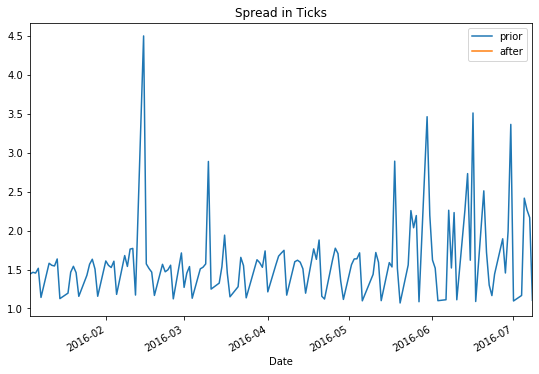

In [170]:
time_series_plot(CAD_PRIOR_OB_UZ_STATS, 'twspr1', 'Spread in Ticks')

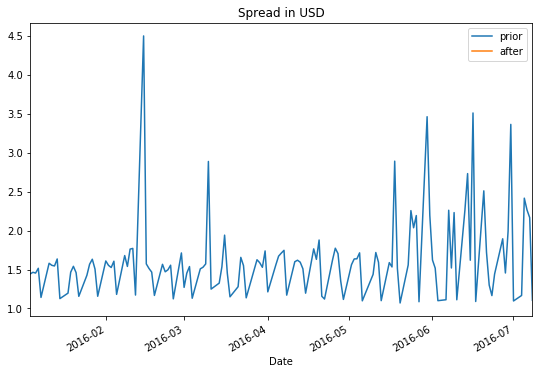

In [171]:
twspr_plot_USD(CAD_PRIOR_OB_UZ_STATS)

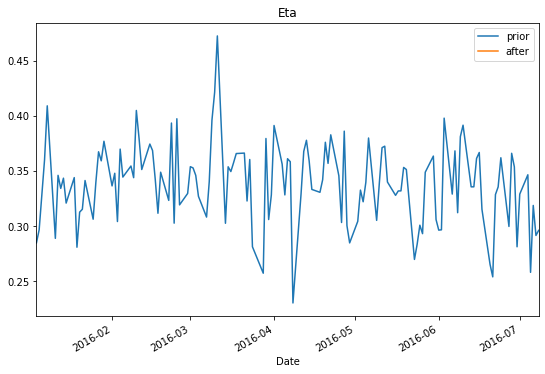

In [172]:
time_series_plot(CAD_PRIOR_OB_UZ_STATS, 'eta1', 'Eta')

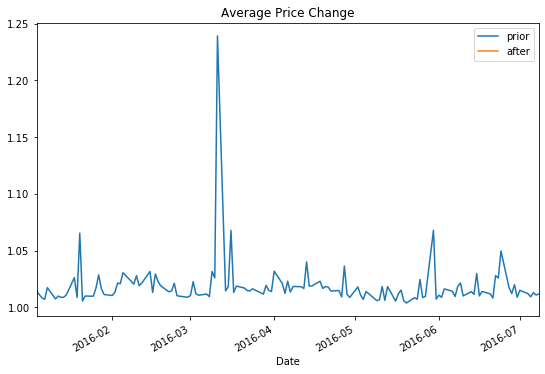

In [173]:
time_series_plot(CAD_PRIOR_OB_UZ_STATS, 'chgavg', 'Average Price Change')

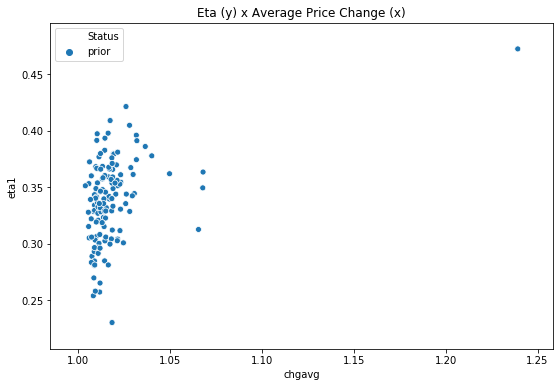

In [174]:
scatter_plot(CAD_PRIOR_OB_UZ_STATS, 'chgavg', 'eta1', 'Eta (y) x Average Price Change (x)')

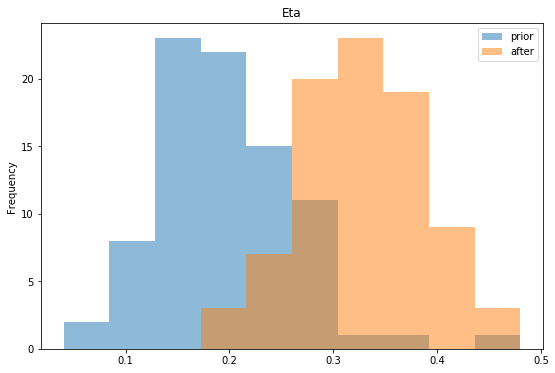

In [112]:
time_series_hist(MXN_OB_UZ_STATS, 'eta1', 'Eta')

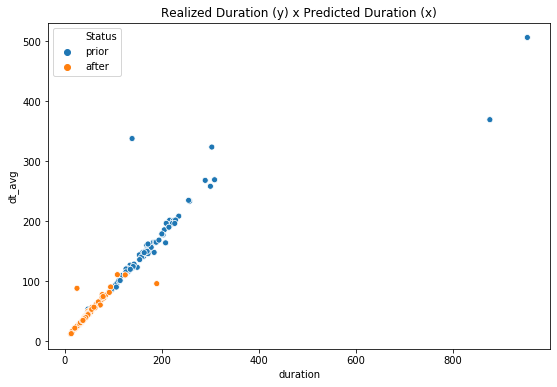

In [113]:
scatter_plot(MXN_OB_UZ_STATS, 'duration', 'dt_avg', 'Realized Duration (y) x Predicted Duration (x)')

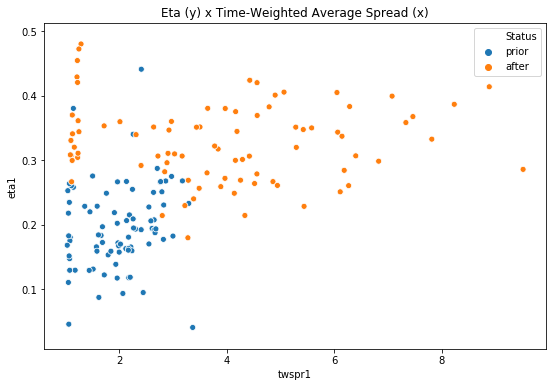

In [114]:
scatter_plot(MXN_OB_UZ_STATS, 'twspr1', 'eta1', 'Eta (y) x Time-Weighted Average Spread (x)')

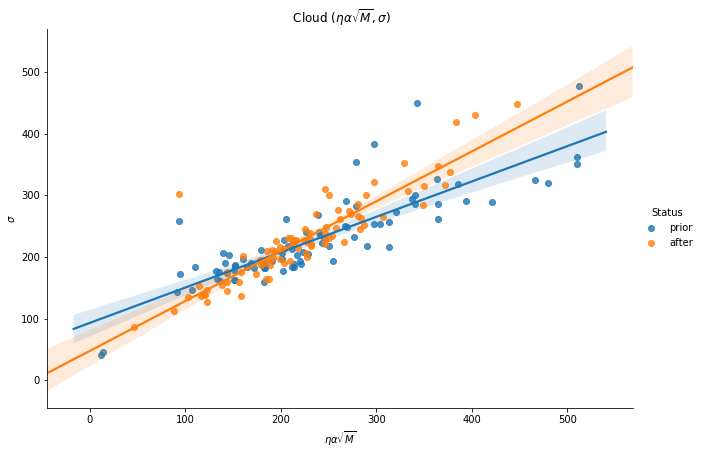

In [115]:
cloud1(MXN_OB_UZ_STATS)

In [116]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     112.1
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.61e-24
Time:                        23:27:08   Log-Likelihood:                -421.03
No. Observations:                  84   AIC:                             848.1
Df Residuals:                      81   BIC:                             855.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                80.8025     11.40

In [117]:
lin_reg(MXN_AFTER_OB_UZ_STATS, ['eta*alpha*sqrt(M)', 'S*sqrt(M)'], 'sigma')

                            OLS Regression Results                            
Dep. Variable:                  sigma   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     189.2
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           2.99e-31
Time:                        23:27:14   Log-Likelihood:                -401.32
No. Observations:                  84   AIC:                             808.6
Df Residuals:                      81   BIC:                             815.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                45.7812      9.95

In [118]:
MXN_OB_UZ_STATS['p1*eta*alpha*sqrt(M)'] = np.where(MXN_OB_UZ_STATS['Status']=='prior', 0.5195, 0.7681)*MXN_OB_UZ_STATS['eta*alpha*sqrt(M)']
MXN_OB_UZ_STATS['sigma-p2*S*sqrt(M)'] = MXN_OB_UZ_STATS['sigma']-\
    np.where(MXN_OB_UZ_STATS['Status']=='prior', 0.0106, 0.0040)*MXN_OB_UZ_STATS['S*sqrt(M)']

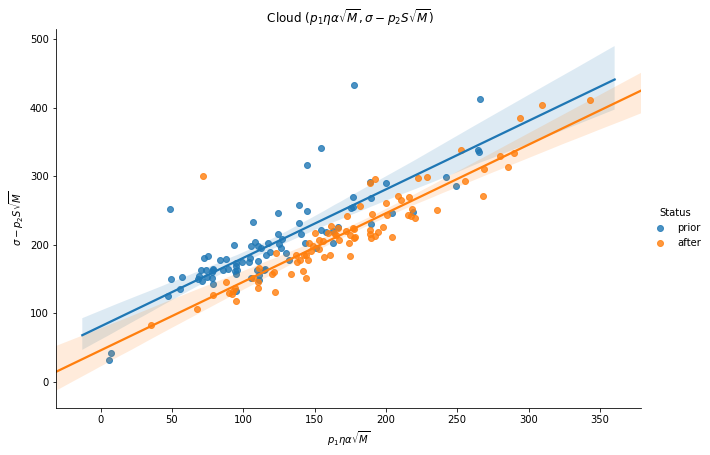

In [120]:
cloud2(MXN_OB_UZ_STATS)

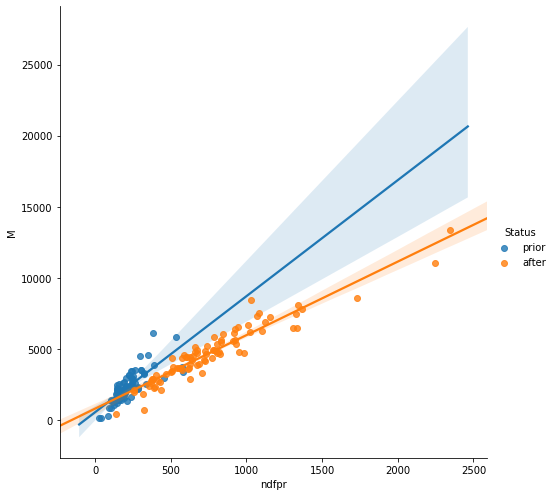

In [121]:
regr_plot(MXN_OB_UZ_STATS, 'ndfpr', 'M')

In [122]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     136.0
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.28e-19
Time:                        23:28:51   Log-Likelihood:                -660.99
No. Observations:                  84   AIC:                             1326.
Df Residuals:                      82   BIC:                             1331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        555.9551    166.679      3.335      0.0

In [123]:
lin_reg(MXN_AFTER_OB_UZ_STATS, 'ndfpr', 'M')

                            OLS Regression Results                            
Dep. Variable:                      M   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     730.1
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           1.38e-42
Time:                        23:28:58   Log-Likelihood:                -663.84
No. Observations:                  84   AIC:                             1332.
Df Residuals:                      82   BIC:                             1337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        805.3680    163.235      4.934      0.0

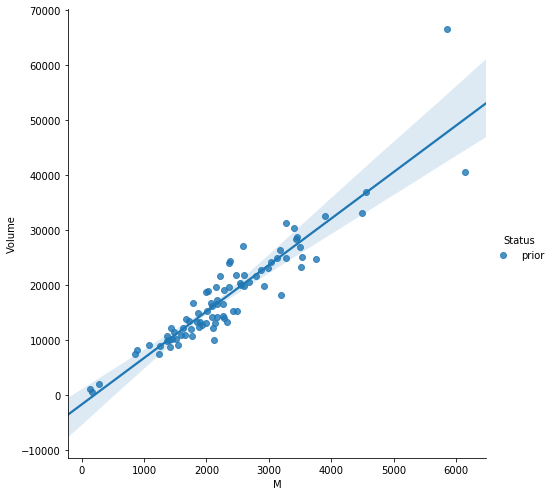

In [124]:
regr_plot(MXN_PRIOR_OB_UZ_STATS, 'M', 'Volume')

In [125]:
lin_reg(MXN_PRIOR_OB_UZ_STATS, 'M', 'Volume')

                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     510.3
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           5.85e-37
Time:                        23:29:09   Log-Likelihood:                -804.53
No. Observations:                  84   AIC:                             1613.
Df Residuals:                      82   BIC:                             1618.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1640.7218    949.912     -1.727      0.0

## Run stats

In [42]:
# DF_STATS_EUR_NI = DF_STATS_EUR.reset_index()

In [43]:
# DF_STATS_MXN_NI = DF_STATS_MXN.reset_index()

## Dataframe of price changes by k

In [ ]:
DF_STATS_EUR_MOVES = pd.DataFrame()
for j in range(len(FILES_EUR_PRIOR_CAticks)):
    new_row = pd.read_csv(FILES_EUR_PRIOR_CAticks[j])
    new_row['Dates'] = DATES_PRIOR_EUR[j].strftime('%Y-%m-%d')
    new_row['Tick'] = TICK_PRIOR_EUR[j]
    new_row['Tick Value'] = TICK_VALUE_PRIOR_EUR[j]
    DF_STATS_EUR_MOVES = DF_STATS_EUR_MOVES.append(new_row)
for j in range(len(FILES_EUR_AFTER_CAticks)):
    new_row = pd.read_csv(FILES_EUR_AFTER_CAticks[j])
    new_row['Dates'] = DATES_AFTER_EUR[j].strftime('%Y-%m-%d')
    new_row['Tick'] = TICK_AFTER_EUR[j]
    new_row['Tick Value'] = TICK_VALUE_AFTER_EUR[j]
    DF_STATS_EUR_MOVES = DF_STATS_EUR_MOVES.append(new_row)
DF_STATS_EUR_MOVES.reset_index()
DF_STATS_EUR_MOVES.set_index(['Dates', 'Tick'], inplace=True)
DF_STATS_EUR_MOVES.sort_index(inplace=True)

In [ ]:
DF_STATS_MXN_MOVES = pd.DataFrame()
for j in range(len(FILES_MXN_PRIOR_CAticks)):
    new_row = pd.read_csv(FILES_MXN_PRIOR_CAticks[j])
    new_row['Dates'] = DATES_PRIOR_MXN[j].strftime('%Y-%m-%d')
    new_row['Tick'] = TICK_PRIOR_MXN[j]
    new_row['Tick Value'] = TICK_VALUE_PRIOR_MXN[j]
    DF_STATS_MXN_MOVES = DF_STATS_MXN_MOVES.append(new_row)
for j in range(len(FILES_MXN_AFTER_CAticks)):
    new_row = pd.read_csv(FILES_MXN_AFTER_CAticks[j])
    new_row['Dates'] = DATES_AFTER_MXN[j].strftime('%Y-%m-%d')
    new_row['Tick'] = TICK_AFTER_MXN[j]
    new_row['Tick Value'] = TICK_VALUE_AFTER_MXN[j]
    DF_STATS_MXN_MOVES = DF_STATS_MXN_MOVES.append(new_row)
DF_STATS_MXN_MOVES.reset_index()
DF_STATS_MXN_MOVES.set_index(['Dates', 'Tick'], inplace=True)
DF_STATS_MXN_MOVES.sort_index(inplace=True)

In [86]:
def get_moves_mat(data_frame, date):
    mat_values = data_frame.copy().loc[date].values
    mat_df = pd.DataFrame(mat_values,\
        columns=['Move in ticks', 'lambda',\
            'Continuations', 'Alternations', 'u', 'eta',\
            'Tick Value'])
    return mat_df

In [45]:
def get_lambda1_mat():
    sub_mat = DF_STATS_MOVES.copy().reset_index()
    sub_mat = sub_mat[sub_mat['Li']==1]\
        [['Product', 'Contract', 'Dates', 'lamb']]
    return sub_mat

In [94]:
SIZES_MOVES_EUR = pd.DataFrame([[date, len(get_moves_mat(DF_STATS_EUR_MOVES,\
    date.strftime('%Y-%m-%d'))), max(get_moves_mat(DF_STATS_EUR_MOVES,\
    date.strftime('%Y-%m-%d'))['Move in ticks'])] for date in DATES_EUR],\
    columns=['Dates', 'Sizes', 'Max move'])
SIZES_MOVES_EUR.set_index(['Dates'], inplace=True)

In [102]:
SIZES_MOVES_MXN = pd.DataFrame([[date, len(get_moves_mat(DF_STATS_MXN_MOVES,\
    date.strftime('%Y-%m-%d'))), max(get_moves_mat(DF_STATS_MXN_MOVES,\
    date.strftime('%Y-%m-%d'))['Move in ticks'])] for date in DATES_MXN],\
    columns=['Dates', 'Sizes', 'Max move'])
SIZES_MOVES_MXN.set_index(['Dates'], inplace=True)

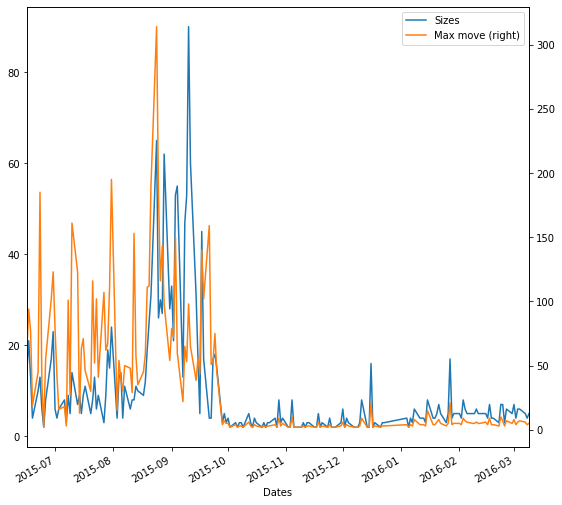

In [103]:
SIZES_MOVES_EUR.plot(secondary_y='Max move', figsize=(9,9));

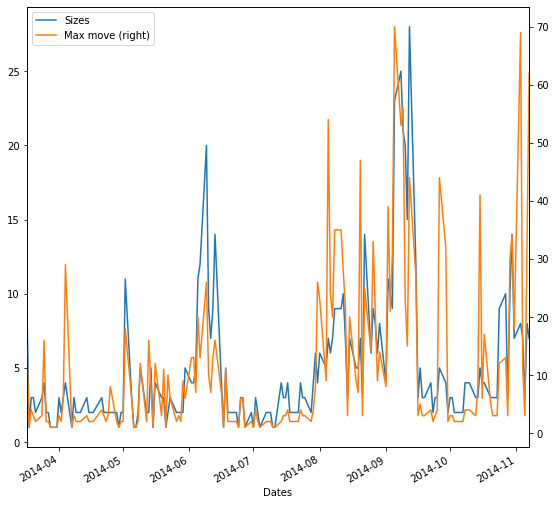

In [104]:
SIZES_MOVES_MXN.plot(secondary_y='Max move', figsize=(9,9));

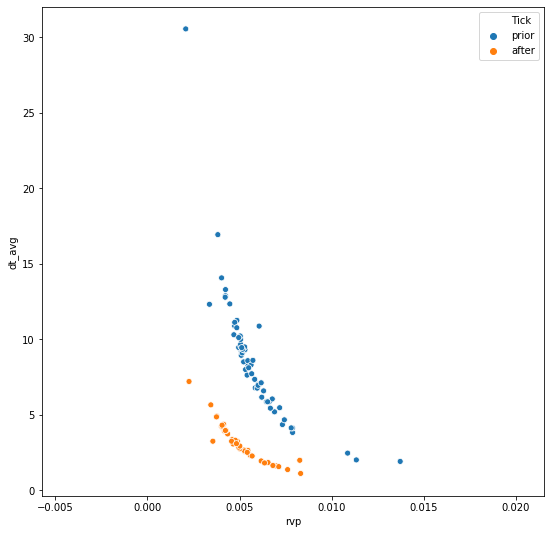

In [56]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='rvp', y='dt_avg', hue='Tick',\
            data=DF_STATS_EUR_2);

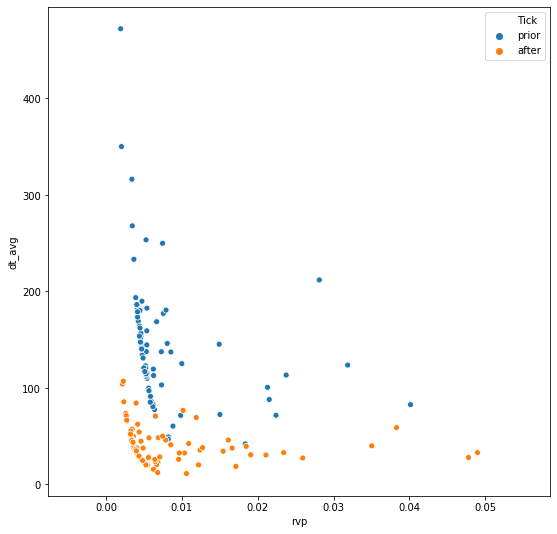

In [57]:
plt.figure(figsize=(9,9))
sns.scatterplot(x='rvp', y='dt_avg', hue='Tick',\
            data=DF_STATS_MXN);

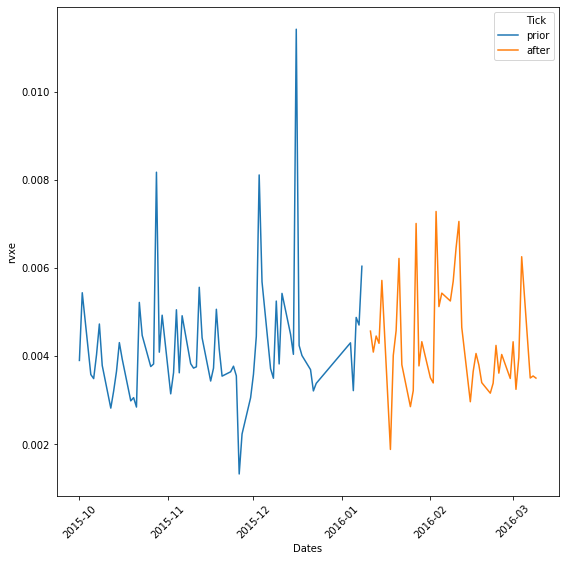

In [58]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvxe', hue='Tick', data=DF_STATS_EUR_NI_2);
plt.xticks(rotation=45);

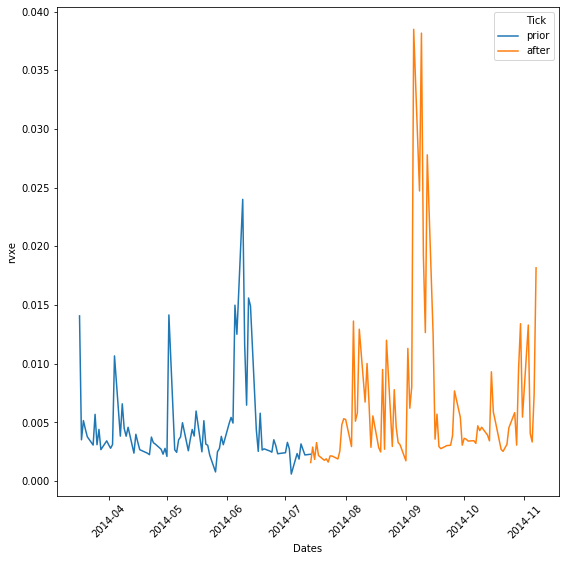

In [59]:
plt.figure(figsize=(9,9))
sns.lineplot(x='Dates', y='rvxe', hue='Tick', data=DF_STATS_MXN_NI);
plt.xticks(rotation=45);

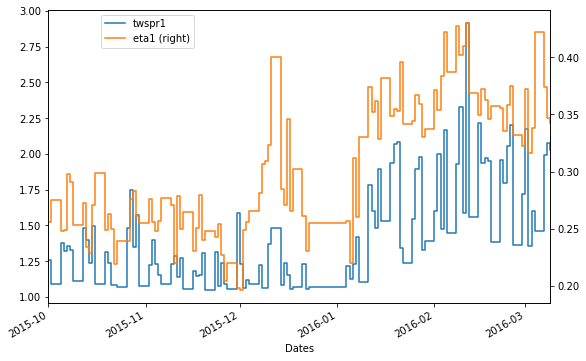

In [60]:
ax = DF_STATS_EUR_2[['twspr1','eta1']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['eta1']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

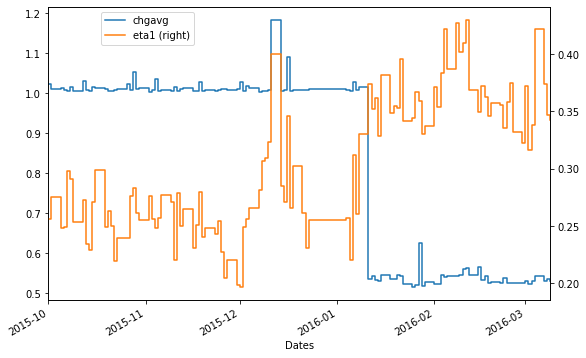

In [61]:
ax = DF_STATS_EUR_2[['chgavg','eta1']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['eta1']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

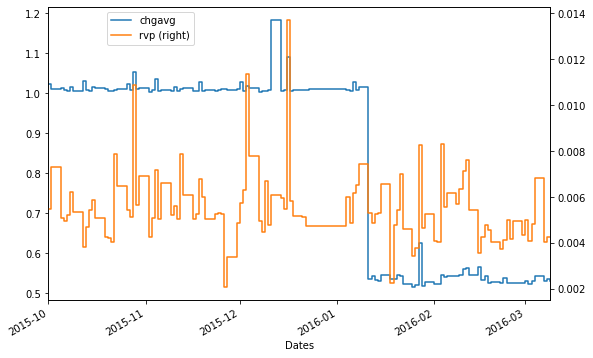

In [62]:
ax = DF_STATS_EUR_2[['chgavg','rvp']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['rvp']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

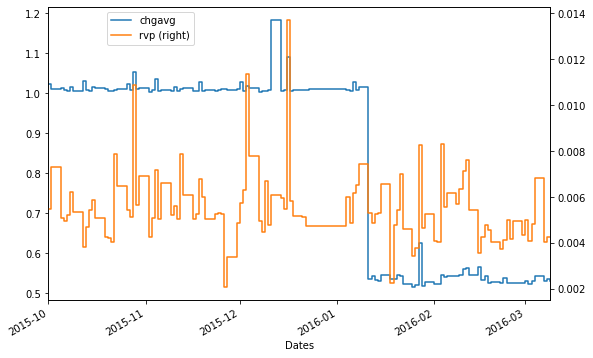

In [63]:
ax = DF_STATS_EUR_2[['chgavg','rvp']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['rvp']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

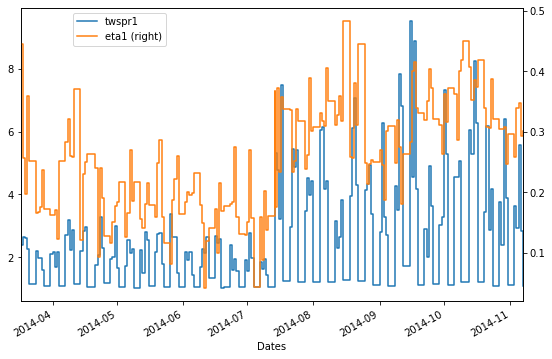

In [64]:
ax = DF_STATS_MXN[['twspr1','eta1']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['eta1']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

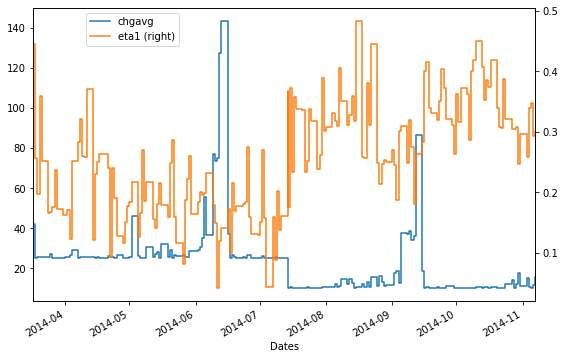

In [65]:
ax = DF_STATS_MXN[['chgavg','eta1']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['eta1']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

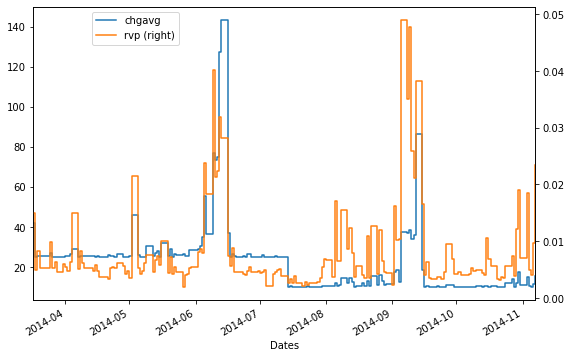

In [66]:
ax = DF_STATS_MXN[['chgavg','rvp']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['rvp']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

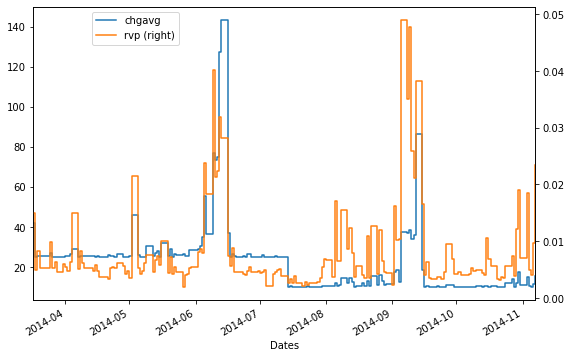

In [67]:
ax = DF_STATS_MXN[['chgavg','rvp']].plot(figsize=(9,6), drawstyle='steps-post', secondary_y=['rvp']);
ax.get_legend().set_bbox_to_anchor((0.3, 1))

In [ ]:
DF_STATS_EUR_COST = pd.DataFrame()
for j in range(len(FILES_EUR_PRIOR_COSTtrades)):
    new_row = pd.read_csv(FILES_EUR_PRIOR_COSTtrades[j])
    new_row['Date'] = DATES_PRIOR_EUR[j].strftime('%Y-%m-%d')
    DF_STATS_EUR_COST = DF_STATS_EUR_COST.append(new_row)
for j in range(len(FILES_EUR_AFTER_COSTtrades)):
    new_row = pd.read_csv(FILES_EUR_AFTER_COSTtrades[j])
    new_row['Date'] = DATES_AFTER_EUR[j].strftime('%Y-%m-%d')
    DF_STATS_EUR_COST = DF_STATS_EUR_COST.append(new_row)
DF_STATS_EUR_COST.set_index('Date', inplace=True)

In [69]:
DF_STATS_EUR_COST_NI = DF_STATS_EUR_COST.reset_index()

In [70]:
DF_STATS_EUR_COST_2 = DF_STATS_EUR_COST.copy().loc['2015-10-01':]
DF_STATS_EUR_COST_NI_2 = DF_STATS_EUR_COST_2.reset_index()

In [71]:
DF_STATS_EUR_COST_2_DATES = DF_STATS_EUR_COST_2.index.unique().values

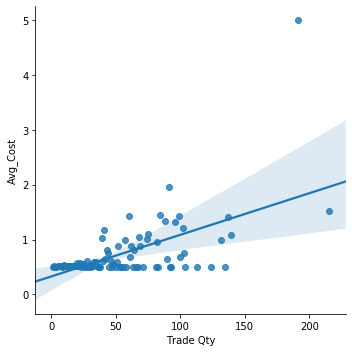

In [72]:
sns.lmplot(x='Trade Qty', y='Avg_Cost', data=DF_STATS_EUR_COST_NI_2[DF_STATS_EUR_COST_NI_2['Date'] == DF_STATS_EUR_COST_2_DATES[0]]);

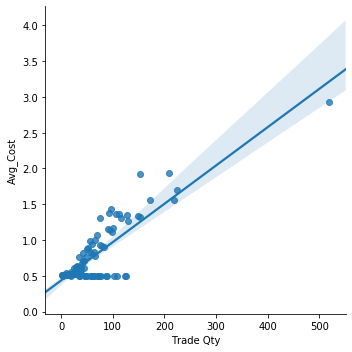

In [73]:
sns.lmplot(x='Trade Qty', y='Avg_Cost', data=DF_STATS_EUR_COST_NI_2[DF_STATS_EUR_COST_NI_2['Date'] == DF_STATS_EUR_COST_2_DATES[1]]);

In [74]:
from pandas.plotting import scatter_matrix

In [75]:
DF_STATS_EUR_2.columns

Index(['ask12qty', 'ask12tomid', 'ask1qty', 'ask1tomid', 'bid12qty',
       'bid12tomid', 'bid1qty', 'bid1tomid', 'twspr1', 'twspr2', 'chgavg',
       'dt_alt', 'dt_avg', 'dt_cont', 'duration', 'eta1', 'ndfpr', 'rvp',
       'rvxe', 'spot_avg', 'Tick', 'Tick Value'],
      dtype='object')

In [76]:
SUB_DF_STATS_EUR_2 = DF_STATS_EUR_2[['twspr1', 'chgavg', 'dt_avg', 'eta1', 'ndfpr', 'rvp']]

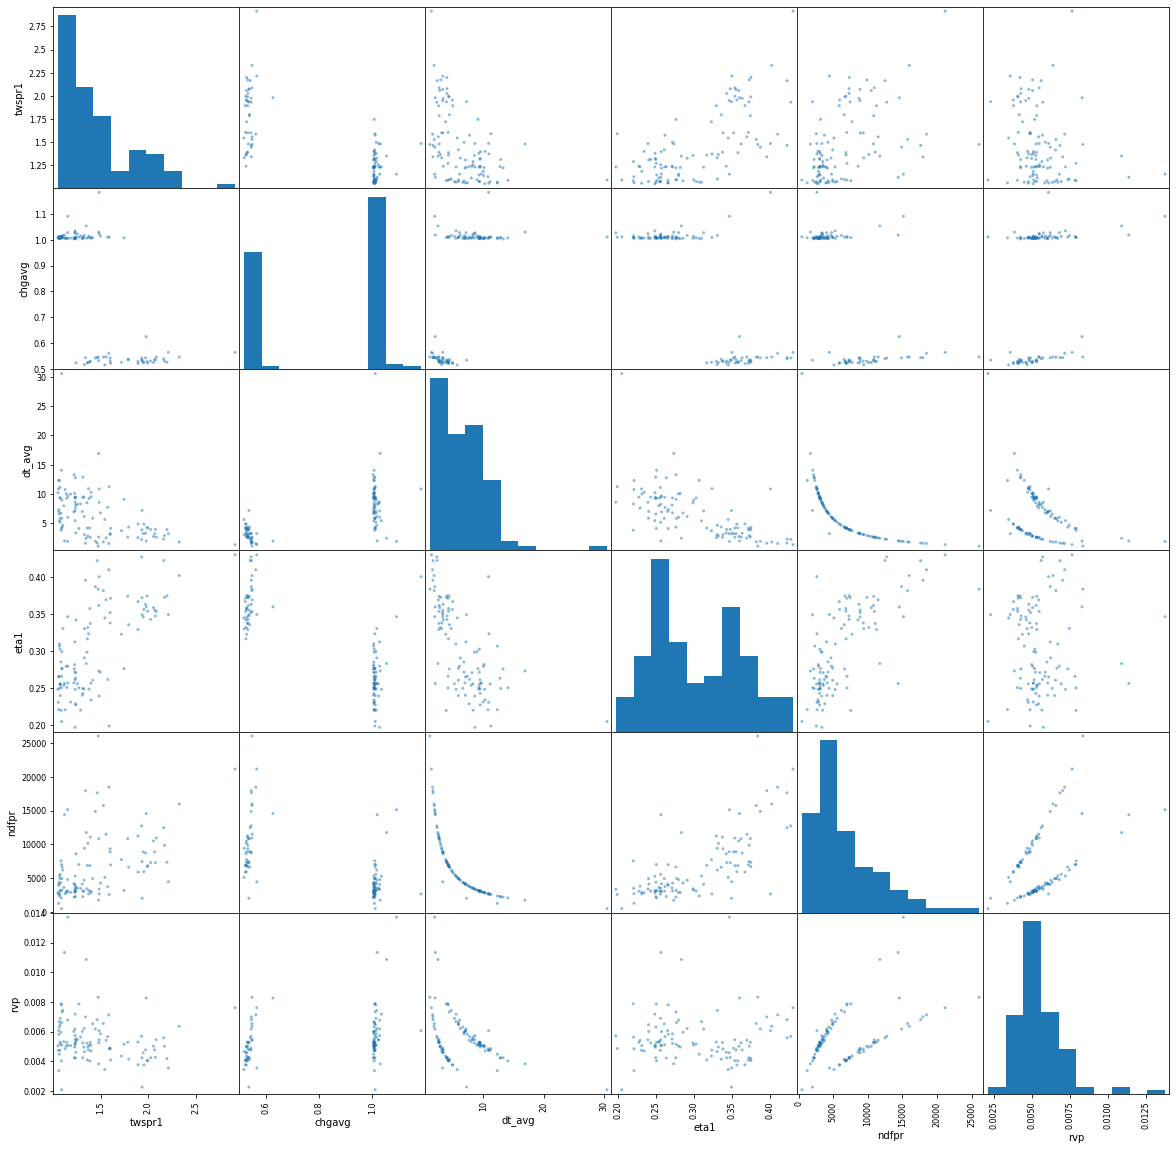

In [77]:
scatter_matrix(SUB_DF_STATS_EUR_2, figsize=(20, 20));